In [ ]:
import requests

YOUR_API_KEY="x"

# four space points which define the area to sample
LAT1="43.680222"#impruneta
LON1="11.262148"
LAT2="43.920469"#montecatini
LON2="10.813944"
LAT3 = "43.780776654855806"#pontassieve
LON3 = "11.370426997738011"
LAT4 = "44.023403841566264" #pistoia nord
LON4 = "10.917749265124229" 

SAMPLES="100"

# sampling one side of the rectangle 
BASE='https://maps.googleapis.com/maps/api/elevation/json?path='+LAT1+'%2C'+LON1+'%7C'+LAT3+'%2C'+LON3+'&samples='+SAMPLES+'&key='+YOUR_API_KEY

r = requests.get(BASE)
print(r.status_code)
print(r.json())

coord_imp_pont = r.json()

# sampling the other side of the rectangle 
BASE='https://maps.googleapis.com/maps/api/elevation/json?path='+LAT2+'%2C'+LON2+'%7C'+LAT4+'%2C'+LON4+'&samples='+SAMPLES+'&key='+YOUR_API_KEY

r = requests.get(BASE)
print(r.status_code)
print(r.json())

coord_mon_pist = r.json()



In [ ]:
# sampling the area between the two sampled sides
alt_map={"results":[]}
SAMPLES="512"
for (point_b,point_t) in zip(coord_imp_pont["results"],coord_mon_pist["results"]):
    print (point_b["location"]["lat"],point_b["location"]["lng"])
    print (point_t["location"]["lat"],point_t["location"]["lng"])
    BASE='https://maps.googleapis.com/maps/api/elevation/json?path='+str(point_b["location"]["lat"])+'%2C'+str(point_b["location"]["lng"])+'%7C'+str(point_t["location"]["lat"])+'%2C'+str(point_t["location"]["lng"])+'&samples='+SAMPLES+'&key='+YOUR_API_KEY
    r = requests.get(BASE)
    print(r.status_code)
    print(r.json()) 
    alt_map["results"].append(r.json()["results"])

print(alt_map["results"])

In [26]:
# dumping the data into a json file
import json
with open("alt_map.json", "w") as file:
    json.dump(alt_map, file)


In [ ]:
# loading the data from a json file
import json
with open("alt_map.json", "r") as file:
    alt_map = json.load( file)

#cleaning
coord_clean = []
for i in alt_map["results"]:
    for coord in i:
        coord_clean.append(coord)
        
coord_clean

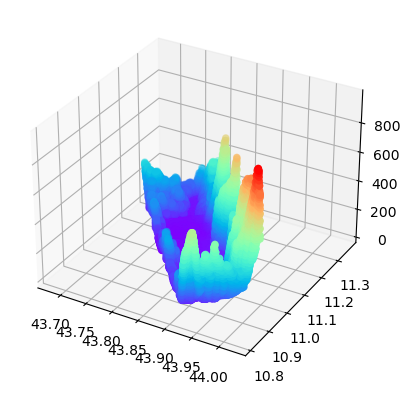

In [2]:
#%matplotlib inline 
#%matplotlib notebook


import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cbook, cm
from matplotlib.colors import LightSource

# Load and format data
z = [float(i["elevation"]) for i in coord_clean]
x = [float(i["location"]["lat"]) for i in coord_clean]
y = [float(i["location"]["lng"]) for i in coord_clean]

z = np.array(z)
x = np.array(x)
y = np.array(y)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# having a look at the data
ax.scatter(x, y, z,c=z, cmap='rainbow')

<IPython.core.display.Javascript object>


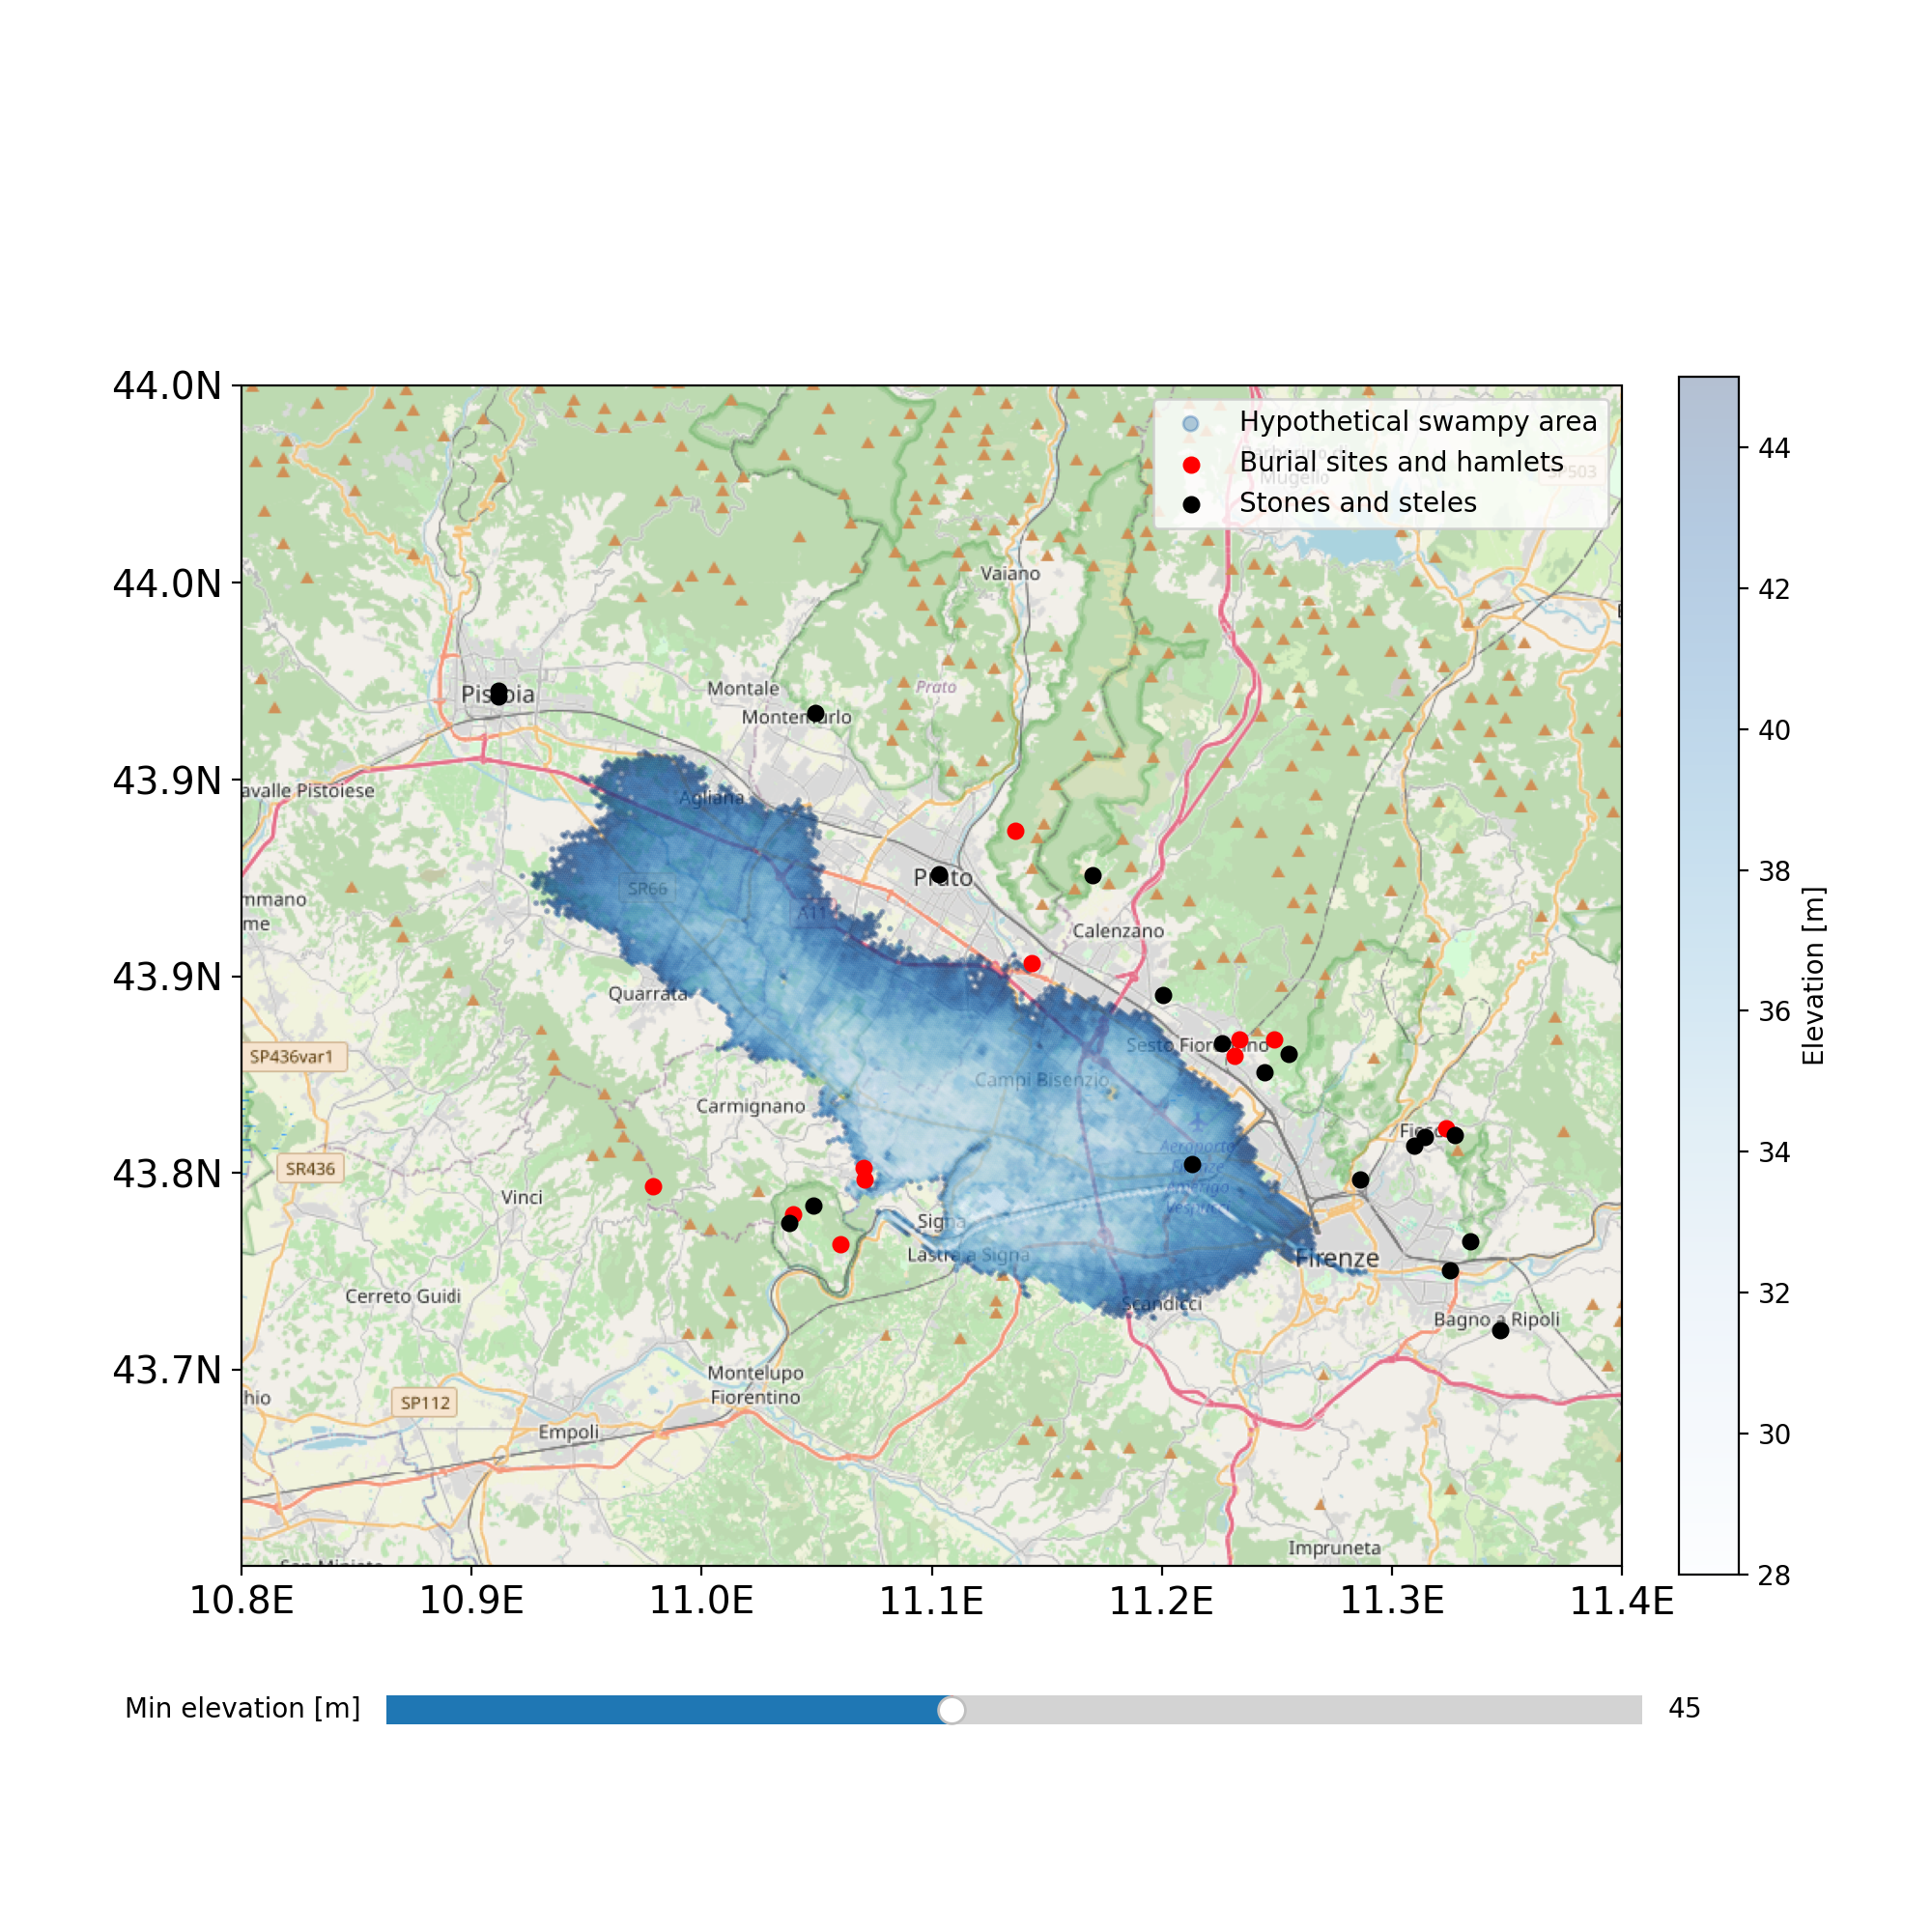

In [4]:
%matplotlib notebook

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.widgets import Slider, Button, RadioButtons
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

# map source
request = cimgt.OSM()
#request = cimgt.QuadtreeTiles() 

# bounds: (lon_min, lon_max, lat_min, lat_max):
extent = [float(LON2), float(LON3), float(LAT1), float(LAT4)]

fig, ax1 = plt.subplots(figsize=(10, 10))
plt.clf()

# setting up the plot for cartography 
ax1 = plt.axes(projection=request.crs)
ax1.set_extent(extent)
ax1.set_xticks(np.linspace(extent[0],extent[1],7),crs=ccrs.PlateCarree()) # set longitude indicators
ax1.set_yticks(np.linspace(extent[2],extent[3],7)[1:],crs=ccrs.PlateCarree()) # set latitude indicators
lon_formatter = LongitudeFormatter(number_format='0.1f',degree_symbol='',dateline_direction_label=True) # format lons
lat_formatter = LatitudeFormatter(number_format='0.1f',degree_symbol='') # format lats
ax1.xaxis.set_major_formatter(lon_formatter) # set lons
ax1.yaxis.set_major_formatter(lat_formatter) # set lats
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)

# add map with zoom specification
ax1.add_image(request, 11) 

# slider
axcolor = 'lightgoldenrodyellow'
axamp = plt.axes([0.2, 0.1, 0.65, 0.03], facecolor=axcolor)
ele_slide = Slider(axamp, 'Min elevation [m]', 0., 100.0, valinit=45)

# generate plotting arrays based on the elevation (z)
xnps=[]
ynps=[]
znps=[]
for (x_i,y_i,z_i) in zip(x,y,z):
  if z_i<45:
    xnps.append(x_i)
    ynps.append(y_i)
    znps.append(z_i)

# update function for the slider    
def update(val):
    elevation = ele_slide.val
    xnps=[]
    ynps=[]
    znps=[]
    for (x_i,y_i,z_i) in zip(x,y,z):
      if z_i<elevation:
        xnps.append(x_i)
        ynps.append(y_i)
        znps.append(z_i)
    lake.set_offsets(np.c_[ynps,xnps])
    lake.set_array(znps)
    lake.set_clim([min(znps), max(znps)])
    lake.set(cmap='Blues')
    fig.canvas.draw_idle()
    
ele_slide.on_changed(update)

# water points
lake  = ax1.scatter(ynps, xnps, s=2, c=znps, cmap='Blues',transform=ccrs.PlateCarree(),alpha=0.3, label='Hypothetical swampy area')

# burial sites and hamlets (fixed sites) 
sites = {}
sites["la_mula"] =  [ 11.214229, 43.828613 ]
sites["gonfienti"] =  [ 11.132479002245713, 43.85581266787596 ]
sites["la_montagnola"] = [ 11.216379058564081, 43.83338441529578 ]
sites["pietramarina"] = [10.97999395795799, 43.790807603469084]
sites["montefortini"] = [11.0649705821541, 43.79281944765861]
sites["tumulo_boschetti"] = [11.064748062531692, 43.79619785311487 ]
sites["palestreto"] = [11.23016207532261, 43.8334546498853 ]
sites["la_pozza"] = [11.125740842644722, 43.89408702925144]
sites["fiesole"] = [11.29933554084887, 43.807784248883664]
sites["artimino"] = [11.03630457261055, 43.782650775863644]
sites["prato_rosello"] = [11.05546234094697, 43.77402009924233]

# stones and steles (possibly mobile sites) 
steles = {}
steles["rocca_motemurlo"] = [11.045346127412383, 43.92839559957323]
steles["stele_camporella"] = [11.209302557622767, 43.83250150337291]
steles["cippo_artimino_2"] = [11.044595256895057, 43.78532473682343 ]
steles["stele_casale"] = [11.235950068230053, 43.82932961136668]
steles["cippo_santommaso"] =[11.321270390749664, 43.748787284074666]
steles["stele_peretola"] = [11.19727428633109, 43.797246454888615]
steles["stele_peruzzi"] = [11.30102371640269, 43.76626849241918]
steles["stele_viacorsica"] =[11.302984732454659, 43.80572354049804]
steles["stele_santanzano"] = [11.290822841732439, 43.80508519209085]
steles["cippi_papiniano"] = [11.286626969736204, 43.80272209337102]
steles["cippo_artimino_3"] =[11.034780142756167, 43.78007774494524]
steles["cippo_pistoia_1"] =[10.917532983226673, 43.93304867441776]
steles["stele_sanmartino_mensola"] =[11.30926782652503, 43.77476291806092]
steles["stele_sanmercuriale"] = [10.91734417029436, 43.93473835956333]
steles["cippo_viadebruni"] = [11.26482121663153, 43.79284955492076]
steles["cippo_castellina"] =[11.226340462444917, 43.823936424752816]
steles["stele_rocchi_casotti"] = [11.0952024948565, 43.88151333137219]
steles["cippo_travalle"] = [11.156977549563425, 43.8813726884312]
steles["cippo_settimello"] = [11.185259900167138, 43.84652738227732]

# plot of etruscan interest points
burials = ax1.scatter(list(zip(*sites.values()))[0], list(zip(*sites.values()))[1], s=30, color='#FF0000',transform=ccrs.PlateCarree(),alpha=1, label='Burial sites and hamlets')
stones = ax1.scatter(list(zip(*steles.values()))[0], list(zip(*steles.values()))[1], s=30, color='#000000',transform=ccrs.PlateCarree(),alpha=1, label='Stones and steles')

# fix the bullet size in the legend
lgnd = ax1.legend(handles=[lake, burials, stones])
for legend_handle in lgnd.legendHandles:
    legend_handle.set_sizes([30])

# plot the color bar     
fig.colorbar(lake,ax=ax1,fraction=0.04, pad=0.038, label="Elevation [m]")
    
fig.savefig('fipopt_map.png', dpi=300)
plt.show()
